In [1]:
from time import time

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from clustering import kmeanspp, VoseAlias

In [2]:
class Chrono:
    def __init__(self):
        self.t = time()
    
    def reset(self):
        self.t = time()
    
    def elapsed(self):
        return time() - self.t
    
chrono = Chrono()

# Speed comparisons

## Sampling speed

Comparing the speed of Vose Alias' sampling with numpy's `choice` method. 

In [160]:
n_runs = 10
ns_to_test = np.unique(np.logspace(0, 7, 10).astype('int32'))

result = {'numpy': np.zeros((ns_to_test.size, n_runs)),
          'vose': np.zeros((ns_to_test.size, n_runs))}

In [161]:
for i, n in tqdm(enumerate(ns_to_test), total=len(ns_to_test)):
    for j in range(n_runs):
        w = np.random.random_sample(n)
        w = w.astype('float32') # Fair comparison
        w = w / w.sum()
        
        chrono.reset()
        sampler = VoseAlias(w)
        sampler.sample(n)
        result['vose'][i, j] = chrono.elapsed()
        
        chrono.reset()
        np.random.choice(n, size=n, p=w)
        result['numpy'][i, j] = chrono.elapsed()

100%|██████████| 10/10 [02:13<00:00, 13.31s/it]


Text(0.5, 1.0, 'Sampling $n$ samples from a $n$-sized histogram')

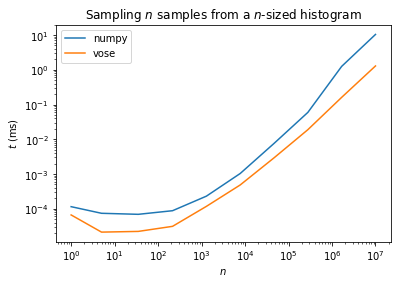

In [162]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
for k, v in result.items():
    ax.plot(ns_to_test, np.mean(v, axis=1), label=k)
ax.legend()
ax.set_xlabel('$n$')
ax.set_ylabel('$t$ (ms)')
ax.set_title('Sampling $n$ samples from a $n$-sized histogram')

Small improvement. Complexity should be $O(n^2)$ for numpy and $O(n)$ for Vose Alias.

## KMeans++ speed

Comparison with Sklearn's methods. 

In [3]:
from sklearn.cluster import KMeans

In [10]:
n_runs = 10
ns_to_test = np.unique(np.logspace(0, 2, 10).astype('int32'))
dim = 2

result = {'sklearn': np.zeros((ns_to_test.size, n_runs)),
          'ours': np.zeros((ns_to_test.size, n_runs))}

In [11]:
for i, n in tqdm(enumerate(ns_to_test), total=len(ns_to_test)):
    for j in range(n_runs):
        X = np.random.random_sample((n**2, dim))
        
        chrono.reset()
        kmeanspp(X, n)
        result['ours'][i, j] = chrono.elapsed()
        
        model = KMeans(n_clusters=n, n_init=1, max_iter=1, init='k-means++')
        chrono.reset()
        model.fit(X)
        result['sklearn'][i, j] = chrono.elapsed()

100%|██████████| 9/9 [00:01<00:00,  4.65it/s]


Text(0.5, 1.0, 'KMeans++ with $n$ centroids on an $n^2$-sized point cloud')

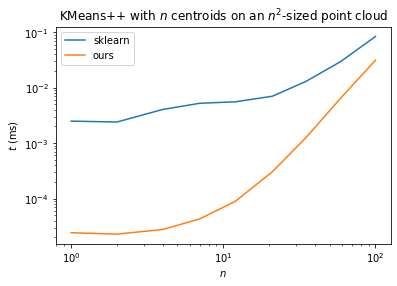

In [13]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
for k, v in result.items():
    ax.plot(ns_to_test, np.mean(v, axis=1), label=k)
ax.legend()
ax.set_xlabel('$n$')
ax.set_ylabel('$t$ (ms)')
ax.set_title('KMeans++ with $n$ centroids on an $n^2$-sized point cloud')

Same theoretical complexity, but 1-2 order of magnitude faster for small values of $n$.